In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.preprocessing as preprocessing
import h5py

from matplotlib.colors import ListedColormap
from skimage import io
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pysptools import spectro, noise
from tqdm import tqdm

find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

def manual_features(dataset, list_of_wavelengths, wavelengths, sigma = None):
    features = np.array([dataset[:, :, find_index(wl, wavelengths)] for wl in list_of_wavelengths])
    if sigma is not None:
        features = np.array([gaussian_filter(f, sigma = sigma) for f in features])
    return features

def plot_kmeans_inertia(X, cluster_range):
    inertias = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters = k, random_state = 10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    fig, ax = plt.subplots(figsize = (5, 4))
    ax.plot(cluster_range, inertias, marker = 'o')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title('K-Means Inertia for Different Cluster Counts', fontsize = 18)
    ax.set_xlabel('Number of Clusters', fontsize = 14)
    ax.set_ylabel('Inertia', fontsize = 14)
    ax.set_xticks(cluster_range)
    ax.grid(True)
    fig.tight_layout()

# 1. Load Datasets

In [2]:
fname = "Data/aligned_libs_hsi.h5"

hf = h5py.File(fname, 'r')

libs_dset = np.array(hf.get("LIBS/Data"))
libs_wavelegths = np.array(hf.get("LIBS/Wavelengths"))

hsi_dset = np.array(hf.get("HSI/Data"))
hsi_wavelegths = np.array(hf.get("HSI/Wavelengths"))

hf.close()

In [8]:
data_size = hsi_dset.shape[:2]
spectral_size_hsi = hsi_dset.shape[2]
spectral_size_libs = libs_dset.shape[2]

In [10]:
end_band = -20 # Remoção das ultimas bandas dos dados de HSI

# Remover ruído
hsi_dset_pro = noise.SavitzkyGolay().denoise_bands(hsi_dset[:, :, :end_band], 5, 3) 
hsi_dset_pro = np.array(hsi_dset_pro)

# Filtragem de dados para remover sinais muito baixos
# correspondentes ao background e possiveis sombras
index = np.where(hsi_dset_pro < 0.1) 
hsi_dset_pro[index] = 0

signals = [np.ndarray.flatten(hsi_dset_pro[ii,jj,:]) for ii in range(0, data_size[0]) for jj in range(0, data_size[1]) ]


# Remoção das curvatura do espetros 
for xy in tqdm(range(0, len(signals))):  
    try:
        norm, x_hull, y_hull = spectro.convex_hull_removal(signals[xy], hsi_wavelegths)
    except: 
        norm = signals[xy]
    signals[xy] = norm

hsi_dset_pro = np.array(signals).reshape(data_size[0], data_size[1], (spectral_size_hsi + end_band))

100%|██████████| 7040/7040 [00:38<00:00, 182.10it/s]


## 1.1 Check Datasets

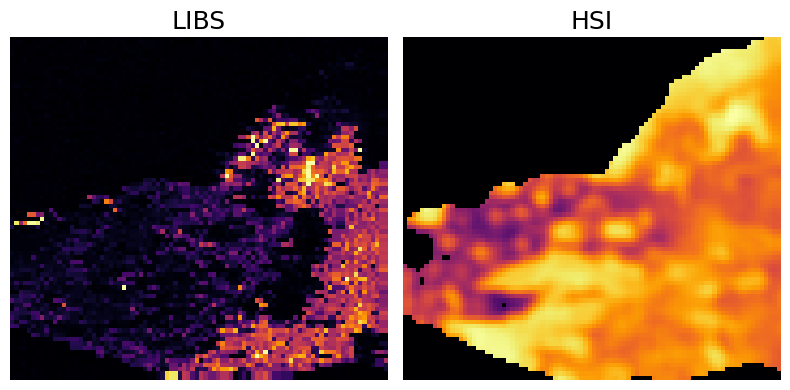

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
ax.imshow(libs_dset[:, :, find_index(610.22, libs_wavelegths)],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("LIBS", fontsize = 18)
ax.axis("off")

ax = axs[1]
ax.imshow(hsi_dset_pro[:, :, find_index(1400, hsi_wavelegths)],
          cmap = 'inferno',
          interpolation = 'nearest')
ax.set_title("HSI", fontsize = 18)
ax.axis("off")

fig.tight_layout()

# 2. Clustering

In [12]:
# Lista com comprimentos de onda relevantes para esta amostra
# Neste caso, temos 3 comprimentos de onda por cada elemento (duas para Rb)
lines = [288.167, 251.590, 252.817, 610.223, 670.764, 812.562, 769.811, 766.398, 693.80,
         568.766, 588.950, 819.400, 309.250, 308.169, 237.227, 779.939, 794.575]

element = ["Si", "Si", "Si", "Li", "Li", "Li", "K", "K", "K", 
           "Na", "Na", "Na", "Al", "Al", "Al", "Rb", "Rb"]

# Extração de features de LIBS + filtro gaussiano
libs_flat = manual_features(libs_dset, lines, libs_wavelegths, sigma = 1)
libs_flat = libs_flat.reshape(libs_flat.shape[0], -1).T

# Filtro Gaussiano nos dados HSI
hsi_flat = gaussian_filter(hsi_dset_pro, axes = (0, 1), sigma = 0.5).reshape(-1, spectral_size_hsi + end_band)

In [13]:
hsi_scaler = preprocessing.MinMaxScaler()
hsi_scaled = hsi_scaler.fit_transform(hsi_flat)

n_comps = 5
pca = PCA(n_components = n_comps) # 4 a 6 componentes explicam mais de 98% da variancia 
hsi_features = pca.fit_transform(hsi_scaled)

In [14]:
np.cumsum(pca.explained_variance_ratio_)

array([0.91248574, 0.96710743, 0.98361607, 0.9879931 , 0.99085192])

In [15]:
libs_scaler = preprocessing.MinMaxScaler()
libs_scaled = libs_scaler.fit_transform(libs_flat)
libs_features = libs_scaled

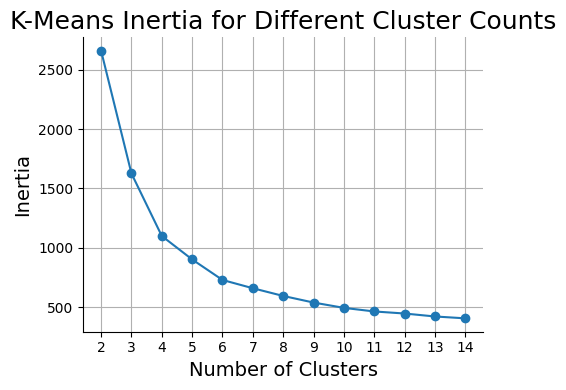

In [16]:
%matplotlib inline
cluster_range = np.arange(2, 15)
plot_kmeans_inertia(libs_features, cluster_range)

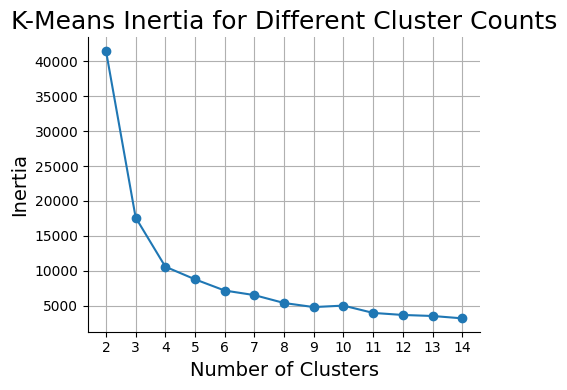

In [17]:
plot_kmeans_inertia(hsi_features, cluster_range)

In [18]:
n_clusters = 5
classifier = KMeans(n_clusters = n_clusters, random_state = 10)

hsi_labels = classifier.fit_predict(hsi_features)
hsi_labels = hsi_labels.reshape(data_size[0], data_size[1])

element = ["Si", "Si", "Si", "Li", "Li", "Li", "K", "K", "K", 
           "Na", "Na", "Na", "Al", "Al", "Al", "Rb", "Rb"]

# Inicialização dos clusters com base na presença ou ausencia de elemento quimica em cada mineral
cluster_inits_libs = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
                               [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                               [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

classifier = KMeans(n_clusters = n_clusters, init = cluster_inits_libs)

libs_labels = classifier.fit_predict(libs_features)
libs_labels = libs_labels.reshape(data_size[0], data_size[1])

In [19]:
hsi_order = [2, 4, 3, 0, 1]
libs_order = [0, 1, 2, 3, 4]

colors = ['xkcd:dark mauve', 'xkcd:pale', 'xkcd:light grey', 'xkcd:greenish grey', 'xkcd:white']
minerals = [r'Lepidolite [$KLi_2AlSi_4O_{10}F(OH)$]', 
            r'Albite [$NaAlSi_3O_8$]',
            r'Quartz [$SiO_2$]',
            r'Mica [$KAl_2(AlSi_3O_{10})(OH)_2$]',
            r'Background']

cmp_libs = ListedColormap([colors[i] for i in libs_order])
cmp_hsi = ListedColormap([colors[i] for i in hsi_order])

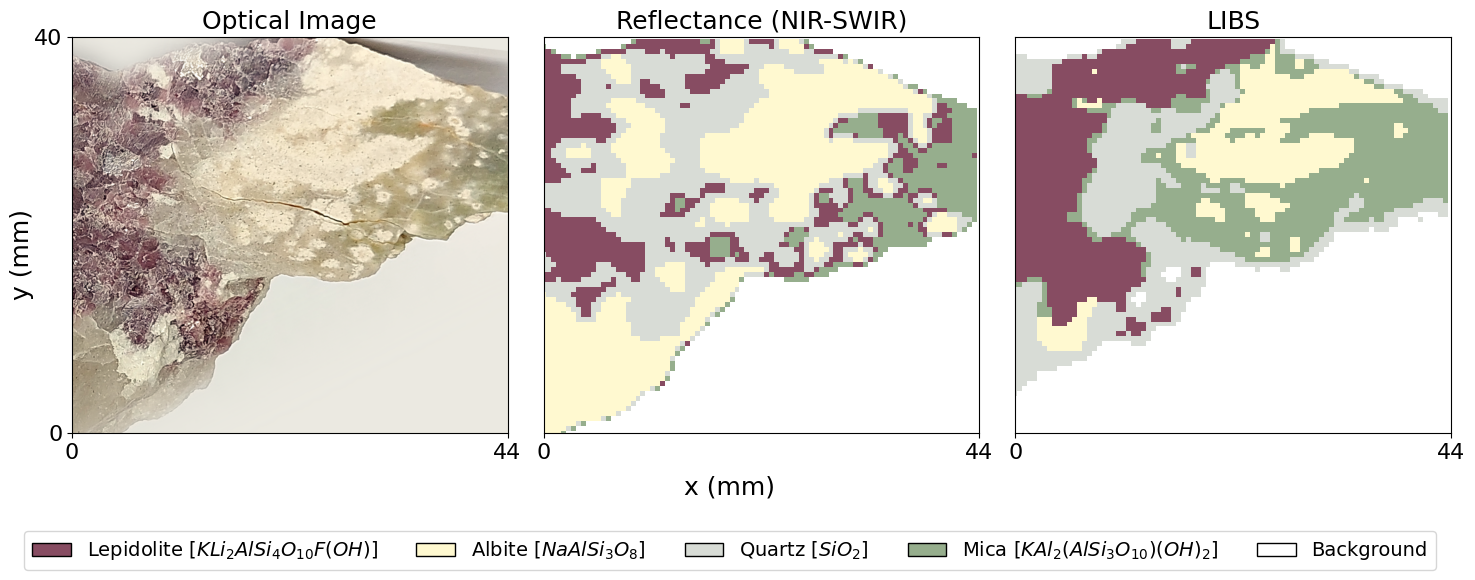

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

ax = axs[0]
ax.imshow(np.array(io.imread("Data/image_bife.png"))[400:1650, 200:1600][::, ::-1], 
          origin = 'lower', 
          extent = (0, data_size[1], 0, data_size[0]))
ax.set_title("Optical Image", fontsize = 18)
ax.set_xticks([0, data_size[1]])
ax.set_xticklabels([0, data_size[1]//2], fontsize = 16)
ax.set_yticks([0, data_size[0]])
ax.set_yticklabels([0, data_size[0]//2], fontsize = 16)
ax.set_xlim(0, data_size[1])
ax.set_ylim(0, data_size[0])

ax = axs[2]
ax.imshow(libs_labels[::, ::-1], cmap = cmp_libs)
ax.set_title("LIBS", fontsize = 18)
ax.set_xticks([0, data_size[1]])
ax.set_xticklabels([0, data_size[1]//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, data_size[1])
ax.set_ylim(0, data_size[0])


ax = axs[1]
ax.imshow(hsi_labels[::, ::-1], cmap = cmp_hsi)
ax.set_title("Reflectance (NIR-SWIR)", fontsize = 18)
ax.set_xticks([0, data_size[1]])
ax.set_xticklabels([0, data_size[1]//2], fontsize = 16)
ax.set_yticks([ ])
ax.set_xlim(0, data_size[1])
ax.set_ylim(0, data_size[0])


handles = []

hls = []
for color,mineral in zip(colors,minerals):
    patch = mpatches.Patch(color = color, label = mineral, ec = 'k')
    hls.append(patch)

fig.supxlabel("x (mm)", fontsize = 18)
fig.supylabel("y (mm)", fontsize = 18)
fig.legend(handles = hls, loc = 'lower center', ncol = 5, fontsize = 14, bbox_to_anchor = (0.5, -0.15))
fig.tight_layout()